In [1]:
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad as quad
from tqdm import tqdm
import emcee

In [2]:
from astropy.table import Table

# Load the fits file
data = Table.read('StellarMassesv19.fits', format='fits')

#print (data.colnames)
filter_data = data[(data['logmstar'] + np.log10(data['fluxscale']) > 9) & (data['Z'] > 0.035) & (data['Z'] < 0.065) & (data['fluxscale'] > 0.3) & (data['fluxscale'] < 3)]

fluxscale = filter_data['fluxscale']
z = filter_data['Z']
logM = filter_data['logmstar']+np.log10(fluxscale)
dlogM = filter_data['dellogmstar']

C:\Users\catch\AppData\Local\Temp\ipykernel_10316\3744097893.py:7: RuntimeWarning: invalid value encountered in log10
  filter_data = data[(data['logmstar'] + np.log10(data['fluxscale']) > 9) & (data['Z'] > 0.035) & (data['Z'] < 0.065) & (data['fluxscale'] > 0.3) & (data['fluxscale'] < 3)]


\begin{equation}
    N_{exp} = \oint dV \oint_{M_l}^{M_h} d\log M
\end{equation}

\begin{equation}
    L = \frac{1}{\sqrt{2\pi N_{exp}}} exp \left[\frac{-1}{2} \left( \frac{N_{obs} - N_{exp}}{\sqrt{Nexp}}\right)^2\right]
\end{equation}

In [3]:
#define all the functions

def schechter_func(ln_mass, phi_star, ln_m_star, alpha):
    x = ln_mass - ln_m_star
    #print(alpha,ln_m_star)
    sch = np.log(10)*phi_star*((10**x)**(alpha+1))*np.exp(-10**x)
    sch = np.where(np.isfinite(sch), sch, 0)
    return sch
    
def schechter_new(ln_mass, phi_star, ln_m_star1, alpha1, ln_m_star2, alpha2, f1):
    sch1 = f1*schechter_func(ln_mass, phi_star, ln_m_star1, alpha1)
    sch2 = (1-f1)*schechter_func(ln_mass,phi_star, ln_m_star2, alpha2)
    return (sch1+sch2)

def schechter_int(ln_mass, phi_star,ln_m_star, alpha):
    # Efficient integral computation
    func = lambda x: np.log(10) * phi_star * (10**((x - ln_m_star) * (alpha + 1))) * np.exp(-10**(x - ln_m_star))
    norm, _ = quad(func, a=np.min(ln_mass), b=np.max(ln_mass))
    return norm

In [8]:
def comoving_volume(z_initial, z_final, H0=70, Omega_M=0.3, Omega_Lambda=0.7):
    c = 3e5 #light speed in km/s as H0 is 70km/s/MPc
    # For a flat universe, Omega_k = 0
    Omega_k = 1 - Omega_M - Omega_Lambda  
    # Hubble distance in Mpc
    DH = c / H0  

    # Angular size distance
    def E(z, Omega_M=Omega_M, Omega_Lambda=Omega_Lambda, Omega_k=Omega_k):
        return np.sqrt(Omega_M * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_Lambda)

    # Integral for comoving distance DC
    def comoving_distance(z):
        return quad(lambda z: 1/E(z), 0, z)[0] * DH

    # Calculate DC for initial and final redshifts
    DC_initial = comoving_distance(z_initial)
    DC_final = comoving_distance(z_final)

    # Volume of the light cone V_C using the formula for Omega_k = 0 (flat universe)
    VC_initial = (4 * np.pi / 3) * DC_initial**3
    VC_final = (4 * np.pi / 3) * DC_final**3

    # The volume covered between z_initial and z_final is the difference
    V_360 = VC_final - VC_initial
    
    #full sky has 41253 sq degrees and GAMA has 250sq degrees
    V_gama = 143/41253 * V_360
    
    return V_gama

# Initial and final redshifts
z_initial = 1e-6
z_final = 0.065

# Calculate and print the volume of the light cone
volume = comoving_volume(z_initial, z_final)
print(f"The volume of the light cone between z={z_initial} and z={z_final} is approximately {volume:.2f} cubic Mpc.")

The volume of the light cone between z=1e-06 and z=0.065 is approximately 300145.55 cubic Mpc.


In [5]:
from astropy.cosmology import Planck15
def co_vol(z_initial, z_final, Omega = 0.0873):
    V23  = Planck15.comoving_volume(z_final) - Planck15.comoving_volume(z_initial)
    V    = Omega/(4*np.pi) * V23
    return V.value

In [6]:
def pslike(ln_mass,phi_star, ln_m_star, alpha):
    #expected Number Counts
    def Nexp(ln_mass, phi_star, ln_m_star, alpha, z_initial=1e-6, z_final=0.065):
        V=comoving_volume(z_initial,z_final)
        phi_int =  schechter_int(ln_mass, phi_star, ln_m_star, alpha)
        Nexp = V * phi_int
        return Nexp
    
    #log Likelihood
    Nobs = len(z)
    Nexp = Nexp(ln_mass,phi_star, ln_m_star, alpha)
    logL =(-1./2)*((Nobs-Nexp)**2)/Nexp -(1/(2*np.log(2*np.pi*Nexp)))
    
    #print(logL, Nobs, Nexp)
    return logL

In [7]:
def lnlike(parvals, data, uncerts, return_model=False):
    alpha, ln_m_star, phi_star = parvals
    ln_mass= data 
    
    if ln_m_star < 8 and phi_star < 0:
        return -np.inf
    
    lnprior = -0.5*( (-2 - alpha)/1.5 )**2.
    # gaussian prior on alpha, centred at -1, with stderr 1.5
    
    # Vectorized calculation of the Schechter function
    sch = schechter_func(ln_mass, phi_star, ln_m_star, alpha)
    
    # Efficient integral computation
    norm = schechter_int(ln_mass, phi_star, ln_m_star, alpha)
    
    const = 1e-10  # To avoid log(0)
    
    #Vectorized log sum and normalization
    #L = np.nansum(np.log(sch + const)) - len(ln_mass) * np.log(norm + const)

    like = np.clip( sch / norm, 1e-12, np.inf )
    L = np.nansum( np.log( like ) )
    
    if return_model :
        return np.clip( sch / norm, 1e-12, np.inf )

    like = np.clip( sch / norm, 1e-12, np.inf )
    L = np.nansum( np.log( like ) )
    
    #print( alpha, ln_m_star, L)
    return L + lnprior #+ pslike(ln_mass, phi_star, ln_m_star, alpha)

In [8]:
def plot_obs_mf(logM, color):
    vol = co_vol(0.035,0.065)
    logmstep=0.1
    bins = np.arange(min(logM), max(logM)+1e-10, logmstep)
    counts, bins = np.histogram(logM, bins)
    mf = counts / logmstep / vol
    plt.plot(bins[:-1],mf, color=color, label='observed', drawstyle='steps-pre')
    
def plot_model_mf(parvals, data, uncert, color):
    
    alpha, ln_m_star, phi_star = parvals
    ln_mass= data 
    
    def ind_like(parvals, data, uncerts):

        # Vectorized calculation of the Schechter function
        sch = schechter_func(ln_mass, phi_star, ln_m_star, alpha)

        # Efficient integral computation
        #norm = schechter_int(ln_mass, phi_star, ln_m_star, alpha)

        like = np.clip( sch, 1e-12, np.inf )
        return like
    
    plt.scatter(data, ind_like(parvals,data,uncert), s=1, color=color, label='model')

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1866.82it/s]


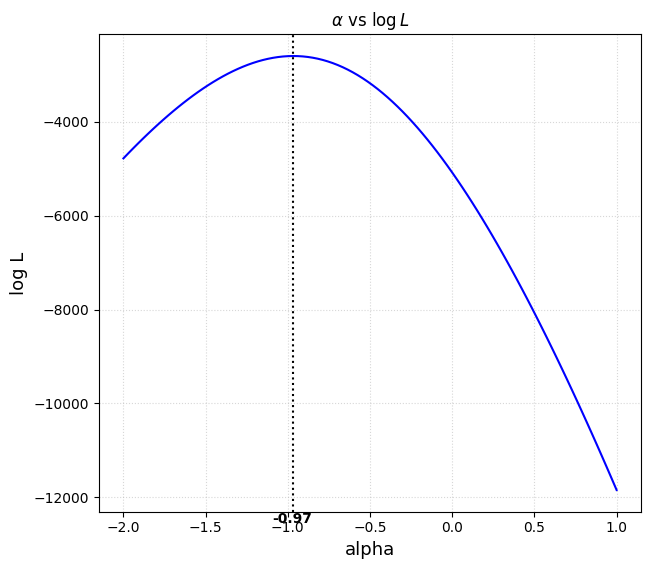

In [9]:
alpha = np.linspace(-2,1,100)
L_values = np.zeros(len(alpha))
L_values2 = np.zeros(len(alpha))


from tqdm import tqdm
for i in tqdm(range(len(alpha))):
    phi_star, logM_star = 3.96e-3, 10.66
    L_values[i] = lnlike((alpha[i],logM_star, phi_star), logM, dlogM)
    #L_values2[i] = lnlike2((alpha[i],logM_star, phi_star), logM, dlogM)

    
plt.figure(figsize=(7,6.2))

minima = alpha[np.argmax(L_values)]

plt.plot(alpha,L_values, color= 'blue')

plt.axvline(x = minima, color = 'black',linestyle=':', label = 'axvline - full height')

plt.text(minima-0.005, plt.gca().get_ylim()[0]-7, str(round(minima,2)), ha='center', va='top', fontweight=1000)

plt.title(r'$\alpha$ vs $\log L$')

plt.grid(alpha=0.5, linestyle=':')

plt.xlabel('alpha', fontsize=13)
plt.ylabel('log L', fontsize=13)

plt.show()

In [10]:
alpha = -1.47, -0.35
phi_star, ln_m_star = 0.79e-3, 10.66 , 3.96e-3
parvals = (alpha, ln_m_star, phi_star)

plt.figure(figsize=(8,7))

plt.yscale('log')
plot_model_mf(parvals,logM, dlogM, 'red')
plot_obs_mf(logM,'blue')

plt.legend()
#plt.ylim(1e-11, 1e-5)

ValueError: too many values to unpack (expected 2)

# 2 Schechter Fit

In [11]:
def schechter_new(parvals, data): #data=logM
    [alpha1, alpha2], log_m_star, [phi_star1,phi_star2]= parvals
    log_mass= data
    x = 10**(data-log_m_star)
    
    sch1 = phi_star1*(x**(alpha1+1))
    sch2 = phi_star2*(x**(alpha2+1))
    return (sch1+sch2)*np.exp(-x)*np.log(10)

def plot_obs_mf(logM, color):
    #vol = co_vol(0.035,0.065)
    vol = comoving_volume(0.035,0.065)
    logmstep=0.1
    bins = np.arange(min(logM), max(logM)+1e-10, logmstep)
    counts, bins = np.histogram(logM, bins)
    mf = counts / logmstep / vol
    #plt.plot(bins[:-1],mf, color=color, label='observed', drawstyle='steps-post')
    plt.scatter(bins[:-1]+0.05,mf, color=color, s=4, label='observed')

    
def plot_2_model_mf(parvals, data, uncert, color):
    
    [alpha1, alpha2], log_m_star, [phi_star1,phi_star2]= parvals
    log_mass= data 
    
    def new_int(alpha, phi_star):
        func = lambda x: np.exp(-x)*(phi_star*(x**alpha))
        norm, _ =  quad(func, a=np.min(log_mass), b=np.max(log_mass))
        return norm
    
    def ind_like(parvals, data, uncerts):

        # Vectorized calculation of the Schechter function
        sch = schechter_new(parvals, data)

        #new integral computation 
        #norm = new_int(alpha1, phi_star1) + new_int(alpha2, phi_star2)
        like = np.clip( sch, 1e-12, np.inf)
        
        return like
    
    plt.scatter(data, ind_like(parvals,data,uncert), s=1, color=color, label='model')

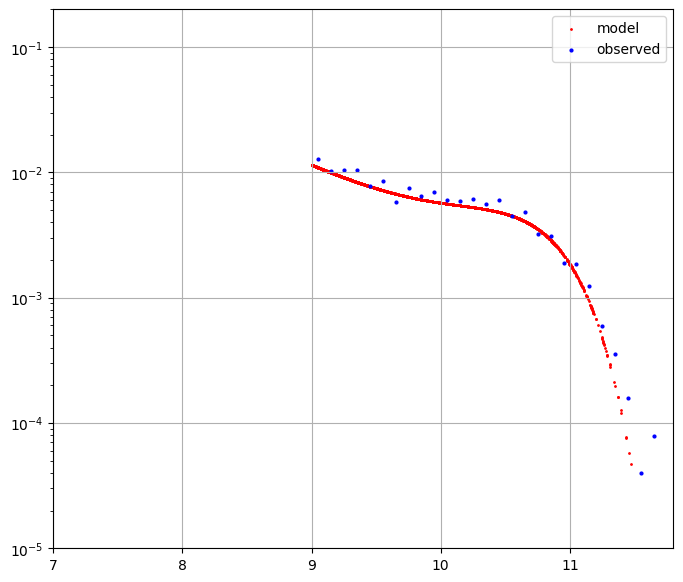

In [12]:
[alpha1, alpha2] = [-1.47, -0.35]
[phi_star1, phi_star2] = [0.79e-3, 3.96e-3]
m_star = 10.66

parvals = [alpha1, alpha2], m_star, [phi_star1, phi_star2]


plt.figure(figsize=(8,7))

plt.yscale('log')
plot_2_model_mf(parvals,logM, dlogM, 'red')
plot_obs_mf(logM,'blue')

plt.legend()
plt.ylim(1e-5, 2e-1)
plt.xlim(7,11.8)

plt.grid()

# double schechter likelihood

In [26]:
from sympy import uppergamma, N

def comoving_volume(z_initial, z_final, H0=70, Omega_M=0.3, Omega_Lambda=0.7):
    c = 3e5 #light speed in km/s as H0 is 70km/s/MPc
    # For a flat universe, Omega_k = 0
    Omega_k = 1 - Omega_M - Omega_Lambda  
    # Hubble distance in Mpc
    DH = c / H0  

    # Angular size distance
    def E(z, Omega_M=Omega_M, Omega_Lambda=Omega_Lambda, Omega_k=Omega_k):
        return np.sqrt(Omega_M * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_Lambda)

    # Integral for comoving distance DC
    def comoving_distance(z):
        return quad(lambda z: 1/E(z), 0, z)[0] * DH

    # Calculate DC for initial and final redshifts
    DC_initial = comoving_distance(z_initial)
    DC_final = comoving_distance(z_final)

    # Volume of the light cone V_C using the formula for Omega_k = 0 (flat universe)
    VC_initial = (4 * np.pi / 3) * DC_initial**3
    VC_final = (4 * np.pi / 3) * DC_final**3

    # The volume covered between z_initial and z_final is the difference
    V_360 = VC_final - VC_initial
    
    #full sky has 41253 sq degrees and GAMA has 250sq degrees
    V_gama = 143/41253 * V_360
    
    return V_gama

# Initial and final redshifts
z_initial = 1e-6
z_final = 0.065

# Calculate and print the volume of the light cone
volume = comoving_volume(z_initial, z_final)
print(f"The volume of the light cone between z={z_initial} and z={z_final} is approximately {volume:.2f} cubic Mpc.")

def lnlike_2model(parvals, data, uncerts, return_model=False):
    alpha1, alpha2, log_m_star, log_phi_star1,log_phi_star2= parvals
    log_mass= data 
    #print(parvals)
    
    if log_m_star < 8 and phi_star1 < 0 and phi_star2 < 0 and log_m_star > 12 and alpha1 > 2 and alpha2 > 2:
        return -np.inf
    
    def new_sch(parvals, data): #data=logM
        x = 10**(data-log_m_star)
        sch1 = (10**log_phi_star1)*(x**(alpha1+1))
        sch2 = (10**log_phi_star2)*(x**(alpha2+1))
        return (sch1+sch2)*np.exp(-x)*np.log(10)
    
    def new_int(parvals, data):
        [a, b] = [min(log_mass) - log_m_star, max(log_mass) - log_m_star]

        # Compute uppergamma values using sympy's N to ensure numerical values
        gamma1_a = float(N(uppergamma(alpha1 + 1, 10**a)))
        gamma1_b = float(N(uppergamma(alpha1 + 1, 10**b)))
        gamma2_a = float(N(uppergamma(alpha2 + 1, 10**a)))
        gamma2_b = float(N(uppergamma(alpha2 + 1, 10**b)))

        norm1 = ((10**log_phi_star1) * (gamma1_a - gamma1_b))
        norm2 = ((10**log_phi_star2) * (gamma2_a - gamma2_b))
        norm = norm1 + norm2

        return(norm)
    
    def pslike(parvals, data):
        #expected Number Counts
        def Nexp(parvals, data, z_initial=0.035, z_final=0.065):
            V=comoving_volume(z_initial,z_final)
            phi_int =  new_int(parvals, data)
            Nexp = V * phi_int
            return Nexp

        #log Likelihood
        Nobs = len(z)
        Nexp = Nexp(parvals, data)
        logL =(-1./2)*((Nobs-Nexp)**2)/Nexp -(1/(2*np.log(2*np.pi*Nexp)))

        #print(logL, Nobs, Nexp)
        return logL
    
    
    lnprior_alpha1 = -0.5 * ((-1 - alpha1) / 1.5) ** 2
    lnprior_alpha2 = -0.5 * ((-1 - alpha2) / 1.5) ** 2
    # gaussian prior on alpha, centred at -1, with stderr 1.5
    lnprior = lnprior_alpha1 + lnprior_alpha2
    
    
    # Vectorized calculation of the Schechter function
    sch = new_sch(parvals, data)
    
    # Efficient integral computation
    norm = new_int(parvals, data)

    like = np.clip( sch / norm, 1e-12, np.inf )
    L = np.nansum( np.log( like ) )
    P = pslike(parvals,data)
    
    if np.isnan(L) or np.isnan(P) or np.isinf(L) or np.isinf(P):
        #print(parvals, L, P)
        return -np.inf
    
    if return_model:
        return like
    
    #print( L,P)
    return L + lnprior + P

The volume of the light cone between z=1e-06 and z=0.065 is approximately 300145.55 cubic Mpc.


In [32]:
[alpha1, alpha2] = [-1.47, -0.35]
[phi_star1, phi_star2] = [0.79e-3, 3.96e-3]
[log_phi_star1, log_phi_star2] = [10**0.79e-3, 10**3.96e-3]

m_star = 10.66

parvals = alpha1, alpha2, m_star, log_phi_star1, log_phi_star2

In [23]:
from sympy import uppergamma, N

def new_int(parvals, data):
    [alpha1, alpha2], log_m_star, [phi_star1, phi_star2] = parvals
    log_mass = data
    [a, b] = [min(log_mass) - log_m_star, max(log_mass) - log_m_star]
    
    # Compute uppergamma values using sympy's N to ensure numerical values
    gamma1_a = float(N(uppergamma(alpha1 + 1, 10**a)))
    gamma1_b = float(N(uppergamma(alpha1 + 1, 10**b)))
    gamma2_a = float(N(uppergamma(alpha2 + 1, 10**a)))
    gamma2_b = float(N(uppergamma(alpha2 + 1, 10**b)))
    
    norm1 = (phi_star1 * (gamma1_a - gamma1_b))
    norm2 = (phi_star2 * (gamma2_a - gamma2_b))
    norm = norm1 + norm2
    
    return(norm)

def quad_int(parvals, data):
    integrand = lambda x : schechter_new( parvals, x )
    result = quad( integrand, data.min(), data.max() )[0]
    return result


def dumb_int(parvals, data):
    integrand = lambda x : schechter_new( parvals, x )
    dx = 1e-3
    xgrid = np.arange( data.min(), data.max() + dx/10., dx )
    ygrid = schechter_new( parvals, xgrid )
    result = np.sum( ygrid ) * dx
    return result

def gamma_int_linear(parvals, data):
    [alpha1, alpha2], log_m_star, [phi_star1,phi_star2]= parvals
    a = 10**(np.min(logM))/(10**log_m_star)
    b = 10**(np.max(logM))/(10**log_m_star)
    gamma1 = gammainc(alpha1+2,a)-gammainc(alpha1+2,b)
    gamma2 = gammainc(alpha2+2,a)-gammainc(alpha2+2,b)
    result = (phi_star1*gamma1) - (phi_star2*gamma2)
    #print(gamma1, alpha1)
    return (result)

def pslike(parvals, data):
    #expected Number Counts
    def Nexp(parvals, data, z_initial=0.035, z_final=0.065):
        V=comoving_volume(z_initial,z_final)
        phi_int =  quad_int(parvals, data)
        #print(phi_int)
        Nexp = V * phi_int
        return Nexp

    #log Likelihood
    Nobs = len(z)
    Nexp = Nexp(parvals, data)
    logL =(-1./2)*((Nobs-Nexp)**2)/Nexp -(1/(2*np.log(2*np.pi*Nexp)))

    print(Nobs, Nexp)
    return logL

In [24]:
a=np.min(logM)
b=np.max(logM)
phi_star1*gammainc(alpha1+3,a)-phi_star1*gammainc(alpha1+3,b)

-3.4745812985386565e-07

In [25]:
print( new_int(parvals, logM) )
print( gamma_int_linear(parvals, logM) )
print( quad_int(parvals, logM) )
print( dumb_int(parvals, logM) )
print( quad_int(parvals, logM) / new_int(parvals, logM) )


0.012480464148224821
0.0032818499988540267
0.012480464148224827
0.012486194664934435
1.0000000000000004


In [30]:
pslike(parvals, logM)

NameError: name 'pslike' is not defined

In [33]:
lnlike_2model(parvals, logM, dlogM)

-13647504.115125092

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 179.40it/s]


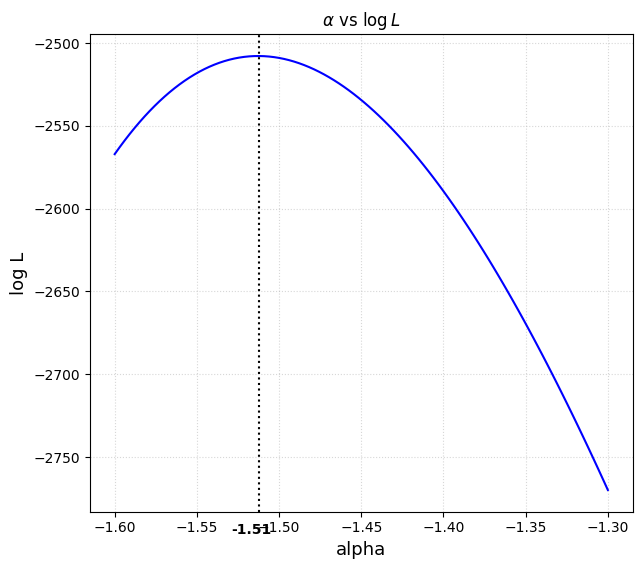

In [38]:
alpha1 = np.linspace(-1.6,-1.3,100)
L_values = np.zeros(len(alpha1))


from tqdm import tqdm
for i in tqdm(range(len(alpha1))):
    parvals = [alpha1[i], alpha2], m_star, [phi_star1, phi_star2]
    L_values[i] = lnlike_2model(parvals, logM, dlogM)

    
plt.figure(figsize=(7,6.2))

minima = alpha1[np.argmax(L_values)]

plt.plot(alpha1,L_values, color= 'blue')

plt.axvline(x = minima, color = 'black',linestyle=':', label = 'axvline - full height')

plt.text(minima-0.005, plt.gca().get_ylim()[0]-7, str(round(minima,2)), ha='center', va='top', fontweight=1000)

plt.title(r'$\alpha$ vs $\log L$')

plt.grid(alpha=0.5, linestyle=':')

plt.xlabel('alpha', fontsize=13)
plt.ylabel('log L', fontsize=13)

plt.show()

# MCMC

In [21]:
#define the parameters for emcee

ndim = 5 #m_star,alpha
nwalkers = 100 #>=2*ndim; the more the better but makes the code slow if too many

#define the initial position of the walkers
p0= np.random.rand(nwalkers, ndim) #we use random initial distribution
mstar00 = 10.5 + 0.5 * np.random.randn(nwalkers)
alpha00 = -1.5 + 0.3 * np.random.rand(nwalkers)
alpha01 = -0.5 + 0.3 * np.random.rand(nwalkers)
phistar00 = 0.8e-3 + 0.0003 * np.random.rand(nwalkers)
phistar01 = 3e-2 + 0.003 * np.random.rand(nwalkers)

p0=np.vstack([alpha00, alpha01,mstar00, phistar00, phistar01]).T

In [22]:
## initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike_2model, args=[logM,dlogM])

In [23]:
#run the sampler
state = sampler.run_mcmc(p0, 10000, progress=True)
#sampler.reset()
#state = sampler.run_mcmc(state.coords, 100, progress=True)

  0%|                                                                              | 6/10000 [00:04<1:57:34,  1.42it/s]C:\Users\catch\AppData\Local\Temp\ipykernel_10316\917158404.py:100: RuntimeWarning: invalid value encountered in divide
  like = np.clip( sch / norm, 1e-12, np.inf )
C:\Users\catch\AppData\Local\Temp\ipykernel_10316\917158404.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  logL =(-1./2)*((Nobs-Nexp)**2)/Nexp -(1/(2*np.log(2*np.pi*Nexp)))
C:\Users\catch\AppData\Local\Temp\ipykernel_10316\917158404.py:82: RuntimeWarning: divide by zero encountered in log
  logL =(-1./2)*((Nobs-Nexp)**2)/Nexp -(1/(2*np.log(2*np.pi*Nexp)))
  0%|▏                                                                            | 23/10000 [00:17<2:16:38,  1.22it/s]C:\Users\catch\AppData\Local\Temp\ipykernel_10316\917158404.py:82: RuntimeWarning: overflow encountered in scalar divide
  logL =(-1./2)*((Nobs-Nexp)**2)/Nexp -(1/(2*np.log(2*np.pi*Nexp)))
  0%|▏                     

emcee: Exception while calling your likelihood function:
  params: [-2.17977922e+00 -1.50318141e-01  1.05196630e+01  7.28774009e-04
  3.17784258e-02]
  args: [<Column name='logmstar' dtype='float32' unit='dex(Msun)' length=3493>
 9.066386
 9.336605
 9.015192
 9.162322
 9.716862
10.206841
 9.753296
 9.153586
11.062106
11.050911
 9.142598
  9.17943
      ...
10.342234
  9.03923
10.219634
10.539152
 9.885678
10.585962
10.067103
  9.94559
10.040696
 9.203746
 9.317579
 9.223535, <Column name='dellogmstar' dtype='float32' unit='dex(Msun)' length=3493>
 0.13166624
 0.13710873
 0.13214754
 0.12614933
0.121676594
 0.11826693
  0.1256789
0.121812366
 0.10861398
  0.1046272
 0.13634151
 0.12881655
        ...
 0.12467896
 0.12616046
0.115959704
 0.13037774
 0.11303722
  0.1500729
0.109345205
  0.1075866
 0.17973271
0.120220326
 0.10673221
 0.12718391]
  kwargs: {}
  exception:


KeyboardInterrupt: 

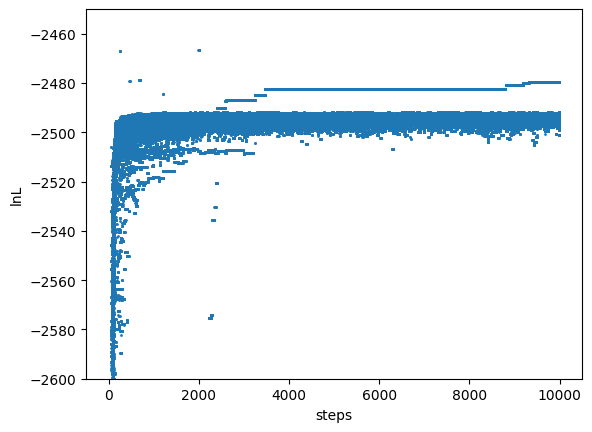

In [14]:
walker, step = np.indices( sampler.chain.shape[:2] )
plt.figure()
plt.scatter( step, sampler.lnprobability, 1)
plt.xlabel("steps")
plt.ylabel('lnL')
plt.ylim([-2600,-2450])
plt.show()

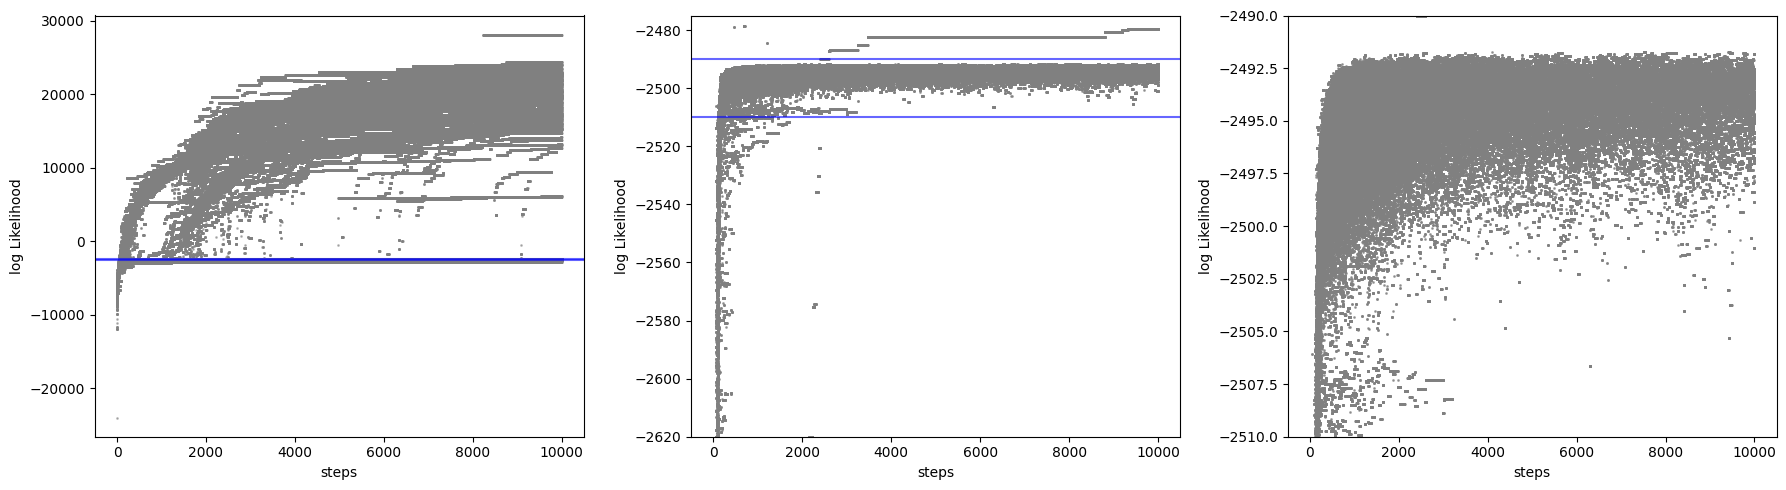

In [16]:
# Create the subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# First subplot: Parameter space plot (Example - you can replace it with any parameter plot)
walker, step = np.indices(sampler.chain.shape[:2])
axs[0].scatter(step, sampler.lnprobability, 1, color='grey', alpha=0.5)
axs[0].axhline(y = -2600, color = 'blue', linestyle = '-', alpha=0.6) 
axs[0].axhline(y = -2450, color = 'blue', linestyle = '-', alpha=0.6) 
axs[0].set_xlabel("steps")
axs[0].set_ylabel("log Likelihood")

# Second subplot: lnL plot
axs[1].scatter(step, sampler.lnprobability, 1, color='grey', alpha=0.7)
axs[1].axhline(y = -2510, color = 'blue', linestyle = '-', alpha=0.6) 
axs[1].axhline(y = -2490, color = 'blue', linestyle = '-', alpha=0.6)
axs[1].set_xlabel("steps")
axs[1].set_ylabel("log Likelihood")
axs[1].set_ylim([-2620, -2475])

# Third subplot: lnL plot
axs[2].scatter(step, sampler.lnprobability, 1, color='grey', alpha=0.7)
axs[2].set_xlabel("steps")
axs[2].set_ylabel("log Likelihood")
axs[2].set_ylim([-2510, -2490])

# Adjust layout
plt.tight_layout()
plt.show()

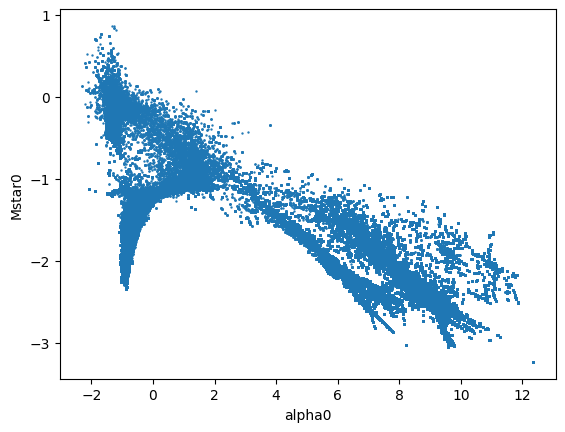

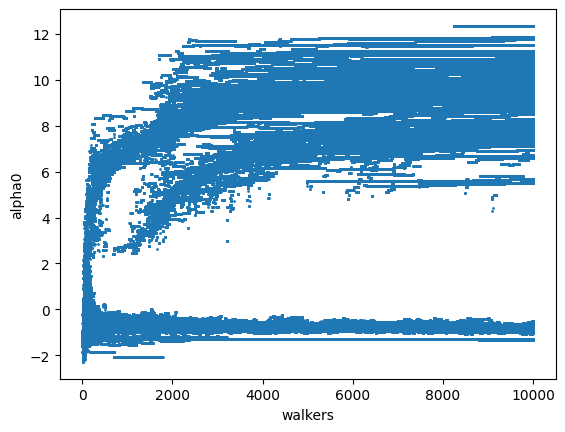

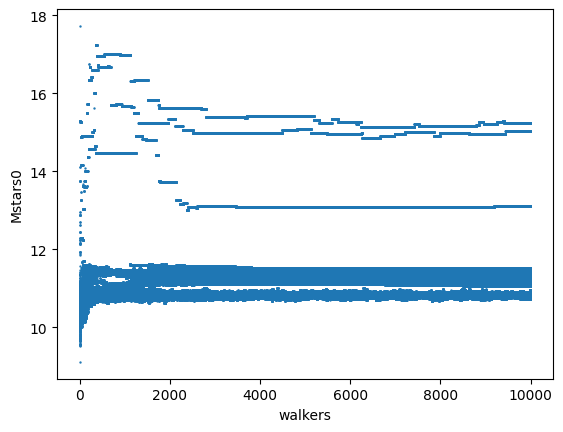

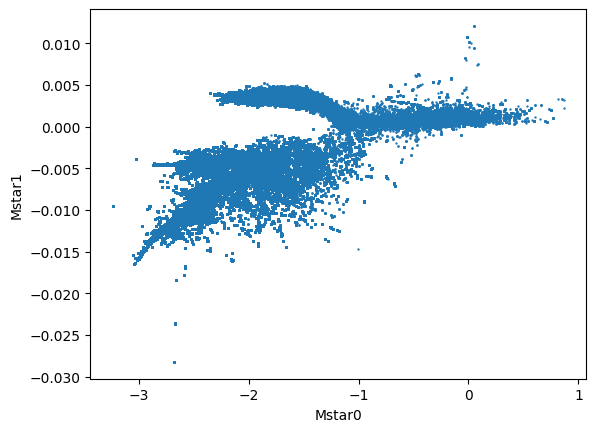

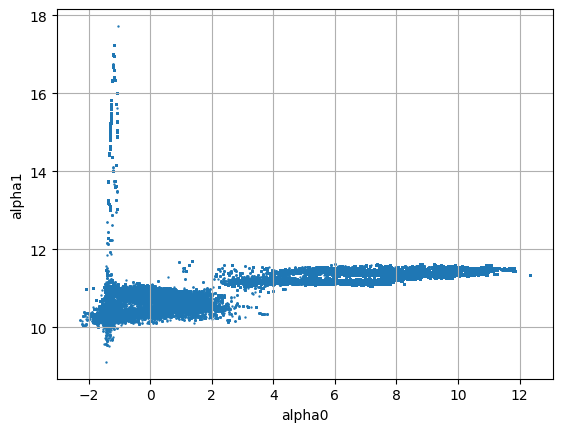

In [17]:
walker, step = np.indices( sampler.chain.shape[:2] )

plt.figure()
plt.scatter( sampler.chain[ ..., 0 ], sampler.chain[ ... , 1 ], .5)
plt.xlabel("alpha0")
plt.ylabel('alpha1')
plt.show()

plt.figure()
plt.scatter( step, sampler.chain[ ..., 0 ] , 1)
plt.xlabel("walkers")
plt.ylabel('alpha0')
plt.show()

plt.figure()
plt.scatter( step, sampler.chain[ ..., 2 ] ,0.5)
plt.xlabel("walkers")
plt.ylabel('m_star')
plt.show()

plt.figure()
plt.scatter( sampler.chain[ ..., 1 ], sampler.chain[ ... , 3 ], .5)
plt.xlabel("")
plt.ylabel('Mstar1')
plt.show()

plt.figure()
plt.scatter( sampler.chain[ ..., 0 ], sampler.chain[ ... , 2 ], .5)
plt.xlabel("alpha0")
plt.ylabel('alpha1')
#plt.xlim(-1.5,-0.5)
#plt.ylim(-1.5,-0.5)
plt.grid()
plt.show()



In [17]:
print(np.argmax(sampler.lnprobability[:, -1]))

39


(100, 1000, 5)
[-1.41107628e+00 -2.73626243e-01  1.03430644e+01  8.21764487e-04
  3.20556555e-02]
[-1.54158276e+00 -6.11240691e-01  1.07608737e+01  5.67986466e-04
  3.71514213e-03]
-5994.486193509556 -2493.777282988178


(0.01, 1)

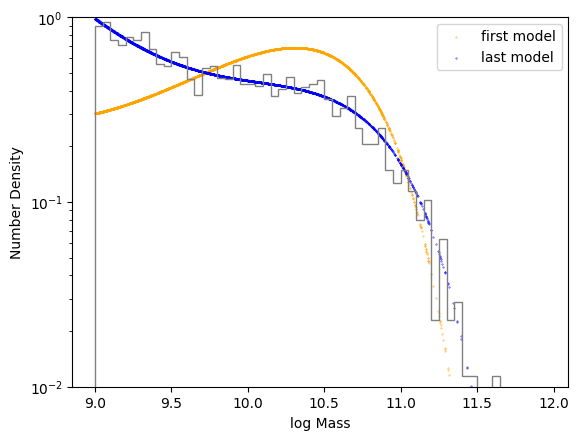

In [18]:
print( sampler.chain.shape )
print( sampler.chain[59,0] )
print( sampler.chain[59,-1] )

args=[logM,dlogM]

first_model = lnlike_2model( sampler.chain[ 40, 0 ], *args, return_model=True )
last_model = lnlike_2model( sampler.chain[ 40, -1 ], *args, return_model=True )

first_lnl = lnlike_2model( sampler.chain[ 0, 0 ], *args )
last_lnl = lnlike_2model( sampler.chain[ 40, -1 ], *args )

print( first_lnl, last_lnl )
plt.clf()
plt.scatter( logM, first_model, .1 , 'orange', label='first model')
plt.scatter( logM, last_model, .1 , 'blue', label = 'last model')

plt.hist( logM, bins=np.arange( 9, 12, .05 ), density=True, histtype='step', color='grey' )

plt.ylabel('Number Density')
plt.xlabel('log Mass')

plt.legend()

plt.yscale('log')
plt.ylim( 1e-2, 1 )

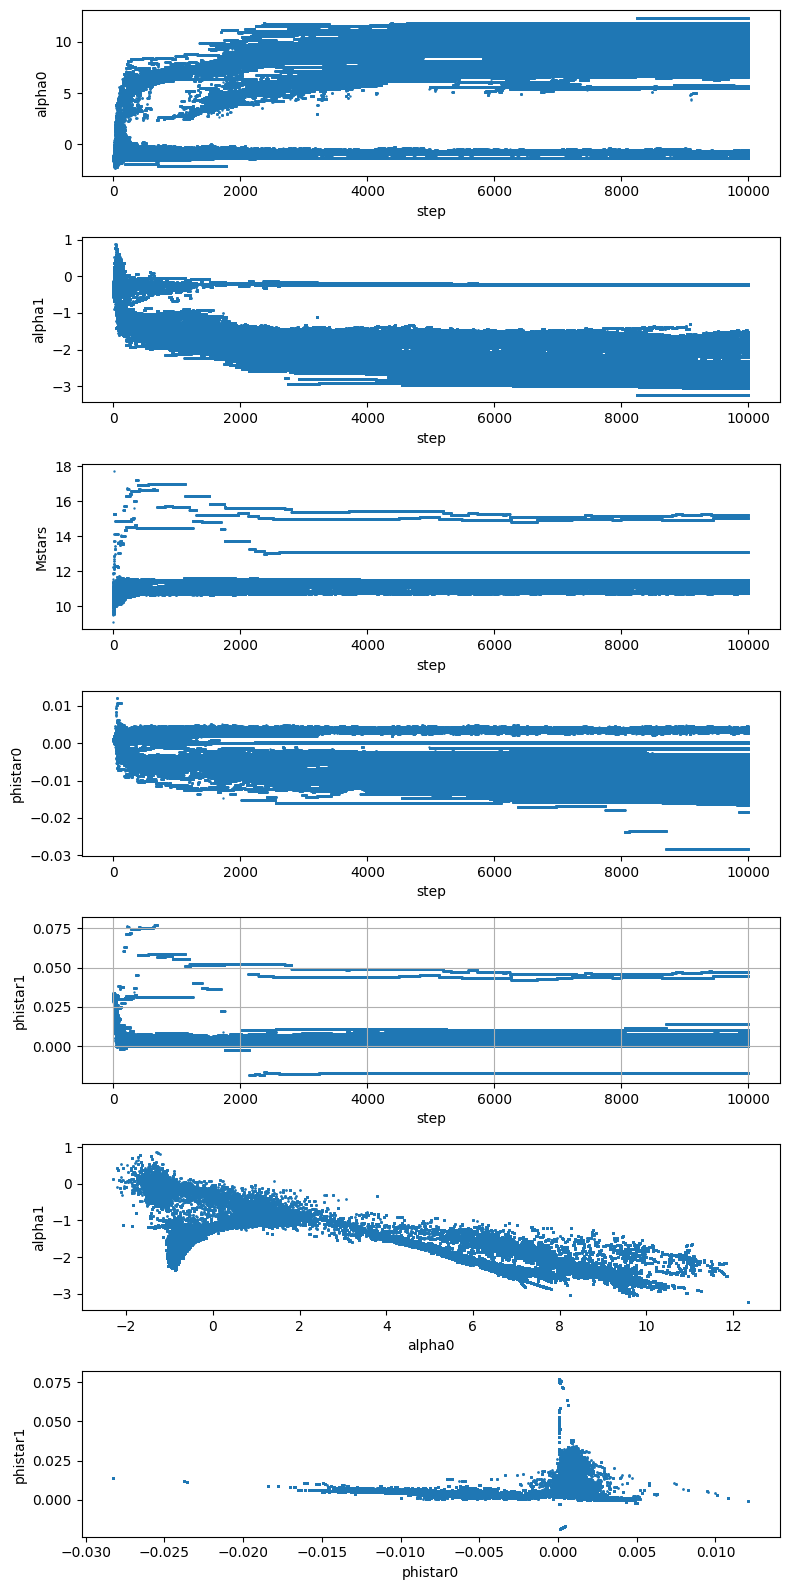

In [18]:
# Create the subplots
fig, axs = plt.subplots(7, 1, figsize=(8, 16))

# First subplot
axs[0].scatter(step, sampler.chain[..., 0], s=0.5)
axs[0].set_xlabel("step")
axs[0].set_ylabel("alpha0")

# Second subplot
walker, step = np.indices(sampler.chain.shape[:2])
axs[1].scatter(step, sampler.chain[..., 1], s=1)
axs[1].set_xlabel("step")
axs[1].set_ylabel("alpha1")

# Third subplot
axs[2].scatter(step, sampler.chain[..., 2], s=0.5)
axs[2].set_xlabel("step")
axs[2].set_ylabel("Mstars")

# Fourth subplot
axs[3].scatter(step, sampler.chain[..., 3], s=0.5)
axs[3].set_xlabel("step")
axs[3].set_ylabel("phistar0")

# Fifth subplot
axs[4].scatter(step, sampler.chain[..., 4], s=0.5)
axs[4].set_xlabel("step")
axs[4].set_ylabel("phistar1")
axs[4].grid()

# Sixth subplot
axs[5].scatter(sampler.chain[..., 0], sampler.chain[..., 1], s=1)
axs[5].set_xlabel("alpha0")
axs[5].set_ylabel("alpha1")

# Seventh subplot
axs[6].scatter(sampler.chain[..., 3], sampler.chain[..., 4], s=1)
axs[6].set_xlabel("phistar0")
axs[6].set_ylabel("phistar1")

# Adjust layout
plt.tight_layout()
plt.show()


In [161]:
print('Expected, Our model(best likelihood walker)')
print('alpha0 = -1.47, ',sampler.chain[40,-1][0])
print('alpha1 = -0.35, ',sampler.chain[40,-1][1])
print('mstar = 10.66, ',sampler.chain[40,-1][2])
print('phistar0 = 0.00079, ',sampler.chain[40,-1][3])
print('phistar1 = 0.00396, ',sampler.chain[40,-1][4])

Expected, Our model(best likelihood walker)
alpha0 = -1.47,  -1.5205238032371804
alpha1 = -0.35,  -0.6385314368248912
mstar = 10.66,  10.796498188344604
phistar0 = 0.00079,  0.000543795806486656
phistar1 = 0.00396,  0.0036921793778361737
